<a href="https://colab.research.google.com/github/RiccardoRasicci/ML-Project/blob/master/MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install --upgrade 'pillow'
!pip3 install 'tqdm'

Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (7.0.0)


In [0]:
import os
import logging
import sys
import numpy as np
import argparse
import random
import warnings
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data 
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
import torch.nn.parallel 
#from torchvision import transforms
import torchvision.transforms as transforms 
import torchvision.models as models 
import torchvision.datasets as datasets 
#from torchvision.models import resnet18
#from torchvision.models import alexnet
from torchvision.models.utils import load_state_dict_from_url
import PIL.Image as Image 
#from PIL import Image
from tqdm import tqdm
import copy

from distutils.dir_util import copy_tree
import shutil




In [0]:
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  
])

saliency_transform = transforms.Compose([transforms.Resize(256),   # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])

In [0]:
#SCRIPT THAT GIVEN A TRAINED MODEL AND THE DATASET COMPUTES THE SALIENCY THROUGH GRAD-CAM AND SAVES THE PATCH AROUND THE PEAK OF THE SALIENCY
#!python gradcam.py --arch 'vgg16' --n-classes 100 -j 4 -b 16 --model '/content/drive/My Drive/grad_cam' '/content/drive/My Drive/real'  

In [0]:
train_path = '/content/drive/My Drive/real'
test_path = '/content/drive/My Drive/painting'
saliency_path = '/content/drive/My Drive/grad_cam/GCAM'

train_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=eval_transform)
saliency_dataset =  torchvision.datasets.ImageFolder(saliency_path, transform=saliency_transform)

print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))
print('Saliency Dataset: {}'.format(len(saliency_dataset)))

Train Dataset: 54784
Test Dataset: 25760
Saliency Dataset: 54784


In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 100
BATCH_SIZE = 16       

LR = 1e-3            
LR_tgt = 1e-6
LR_discr = 1e-3
MOMENTUM = 0.9      
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 5      
STEP_SIZE = 7       
GAMMA = 0.1       


LOG_FREQUENCY = 10

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
saliency_dataloader = DataLoader(saliency_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,drop_last = True)

In [0]:


__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    #'vgg16': 'https://s3.amazonaws.com/pytorch/models/vgg16-397923af.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = self.classifier(x)
        x = self.classifier[0](x)
        x = self.classifier[1](x)
        x = self.classifier[2](x)
        x = self.classifier[3](x)
        x = self.classifier[4](x)
        x = self.classifier[5](x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def vgg11(pretrained=False, progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)


def vgg11_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11_bn', 'A', True, pretrained, progress, **kwargs)


def vgg13(pretrained=False, progress=True, **kwargs):
    r"""VGG 13-layer model (configuration "B")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13', 'B', False, pretrained, progress, **kwargs)


def vgg13_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 13-layer model (configuration "B") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13_bn', 'B', True, pretrained, progress, **kwargs)


def vgg16(pretrained=False, progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)


def vgg16_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)


def vgg19(pretrained=False, progress=True, **kwargs):
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19', 'E', False, pretrained, progress, **kwargs)


def vgg19_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 19-layer model (configuration 'E') with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19_bn', 'E', True, pretrained, progress, **kwargs)

#####################################
# VGG CLASSIFIER, LAST LAYER OF VGG #
#####################################

class Vgg_classifier(nn.Module):
  """VGG classifier model for ADDA."""

  def __init__(self):
      """Init VGG encoder."""
      super(Vgg_classifier, self).__init__()
      self.fc = nn.Linear(4096,NUM_CLASSES) #20 #NUM_CLASSES
      
  def forward(self, x):
      #x = self.features(x)
      #x = self.avgpool(x)
      #x = torch.flatten(x, 1)
      x = self.fc(x)
      return x

In [0]:
#Discriminator for ADDA, Fully Connected Layers 

class Discriminator(nn.Module):
    """Discriminator model for source domain."""

    def __init__(self):
        """Init discriminator."""
        super(Discriminator, self).__init__()

        self.restored = False

        self.layer = nn.Sequential(
            nn.Linear(4096, 500),  
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 2),
            nn.LogSoftmax()
        )

    def forward(self, input):
        """Forward the discriminator."""
        out = self.layer(input)
        return out

In [0]:
def denormalize(inp, title=None, **kwargs):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size()
    H=49
    W=16
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal

class Flatten(nn.Module):
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

In [0]:
#Source net
src_encoder = vgg16(pretrained = True)
src_classifier = Vgg_classifier()
src_encoder.classifier[6] = nn.Sequential(*[src_encoder.classifier[i] for i in range(6)]) #delete the last layer
print(src_encoder.classifier)

#Target net
tgt_encoder = vgg16(pretrained = True)
tgt_encoder.classifier[6] = nn.Sequential(*[tgt_encoder.classifier[i] for i in range(6)]) #delete the last layer
print(tgt_encoder.classifier)

#Evidence net
evidence_encoder = vgg16(pretrained = True)
evidence_classifier = Vgg_classifier()


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
  )
)
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, o

Starting epoch 1/5, LR = [0.001]
Step 0, Loss 4.713348865509033
Step 10, Loss 4.464717388153076
Step 20, Loss 4.590317726135254
Step 30, Loss 4.775928974151611
Step 40, Loss 4.59471321105957
Step 50, Loss 4.5011749267578125
Step 60, Loss 4.644313812255859
Step 70, Loss 4.5069804191589355
Step 80, Loss 4.402587413787842
Step 90, Loss 4.399096488952637
Step 100, Loss 4.556825160980225
Step 110, Loss 4.450524806976318
Step 120, Loss 4.235389232635498
Step 130, Loss 4.407645225524902
Step 140, Loss 3.981003761291504
Step 150, Loss 3.773704767227173
Step 160, Loss 3.3142189979553223
Step 170, Loss 3.398442506790161
Step 180, Loss 3.1765246391296387
Step 190, Loss 3.5766143798828125
Step 200, Loss 3.1784448623657227
Step 210, Loss 2.536832571029663
Step 220, Loss 3.5523524284362793
Step 230, Loss 3.07024884223938
Step 240, Loss 2.6562256813049316
Step 250, Loss 2.799959421157837
Step 260, Loss 2.795896053314209
Step 270, Loss 2.2139477729797363
Step 280, Loss 3.2734947204589844
Step 290, Los

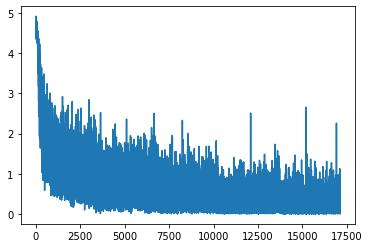

In [0]:
criterion = nn.CrossEntropyLoss() 

parameters_to_optimize = src_encoder.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
src_encoder = src_encoder.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
src_classifier = src_classifier.to(DEVICE)

source_loss_vector = []

cudnn.benchmark 

current_step = 0
# Start iterating over the epochs

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    src_encoder.train()
    src_classifier.train() 
 
    optimizer.zero_grad() 
    
    outputs = src_classifier(src_encoder(images))


    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    source_loss_vector.append(loss)
    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))


    loss.backward()  #
    optimizer.step() #

    current_step += 1

  
  scheduler.step() 


source_model = copy.deepcopy(src_encoder)  
source_classifier = copy.deepcopy(src_classifier) 

plt.plot(source_loss_vector)
plt.show()
#torch.save(src_encoder, src_encoder_path+'src_encoder.pt')
#torch.save(src_classifier, src_classifier_path+'src_classifier.pt')

In [0]:
#Test on source
src_encoder = src_encoder.to(DEVICE)
src_encoder.train(False)

src_classifier = src_classifier.to(DEVICE)
src_classifier.train(False)

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)
  
  outputs = src_classifier(src_encoder(images))
  _, preds = torch.max(outputs.data, 1)
  
  running_corrects += torch.sum(preds == labels.data).data.item()

src_accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy on Target Domain before Adaptation: {}'.format(src_accuracy))


100%|██████████| 1610/1610 [47:17<00:00,  1.74s/it]

Test Accuracy on Target Domain before Adaptation: 0.5218555900621118


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Streaming output truncated to the last 5000 lines.
Epoch [2/5] Step [1442/1610]: discriminator_loss = 0.60262, target_loss = 0.44441, acc = 0.50000
Epoch [2/5] Step [1443/1610]: discriminator_loss = 0.52290, target_loss = 0.41897, acc = 0.50000
Epoch [2/5] Step [1444/1610]: discriminator_loss = 0.59347, target_loss = 0.40432, acc = 0.50000
Epoch [2/5] Step [1445/1610]: discriminator_loss = 0.59118, target_loss = 0.41199, acc = 0.50000
Epoch [2/5] Step [1446/1610]: discriminator_loss = 0.53077, target_loss = 0.42382, acc = 0.50000
Epoch [2/5] Step [1447/1610]: discriminator_loss = 0.53538, target_loss = 0.41605, acc = 0.50000
Epoch [2/5] Step [1448/1610]: discriminator_loss = 0.58546, target_loss = 0.39689, acc = 0.50000
Epoch [2/5] Step [1449/1610]: discriminator_loss = 0.55919, target_loss = 0.38253, acc = 0.50000
Epoch [2/5] Step [1450/1610]: discriminator_loss = 0.56883, target_loss = 0.40750, acc = 0.50000
Epoch [2/5] Step [1451/1610]: discriminator_loss = 0.57295, target_loss = 0.

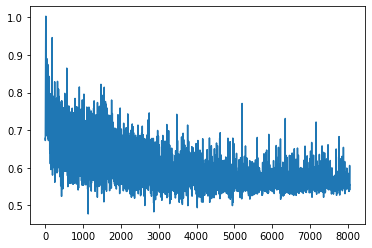

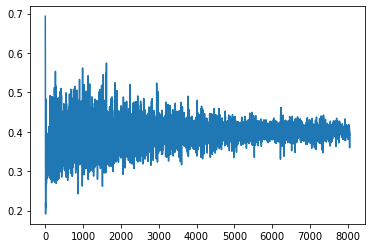

In [0]:
#Train discriminator
critic = Discriminator()
loss_critic_vector = []
target_loss_vector = []
tgt_encoder = source_model

criterion = nn.CrossEntropyLoss() 
tgt_parameters_to_optimize = tgt_encoder.parameters() 
target_optimizer = optim.SGD(tgt_parameters_to_optimize, lr=LR_tgt, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

critic_parameters_to_optimize = critic.parameters()
critic_optimizer = optim.SGD(critic_parameters_to_optimize, lr=LR_discr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.StepLR(target_optimizer, step_size=STEP_SIZE, gamma=GAMMA)

cudnn.benchmark

current_step = 0

tgt_encoder = tgt_encoder.to(DEVICE)
src_encoder = src_encoder.to(DEVICE)
critic = critic.to(DEVICE)

for epoch in range(NUM_EPOCHS):

  data_zip = enumerate(zip(train_dataloader, test_dataloader))
  for step, ((images_src, _), (images_tgt, _)) in data_zip:
    
    #######################
    # Train Discriminator #
    #######################

    images_src = images_src.to(DEVICE)
    images_tgt = images_tgt.to(DEVICE)   

    tgt_encoder.train()
    
    critic.train()

    target_optimizer.zero_grad()

    # extract and concat features  outputs
    feat_src = src_encoder(images_src)
    feat_tgt = tgt_encoder(images_tgt)
    feat_concat = torch.cat((feat_src, feat_tgt), 0)

    # predict on discriminator
    pred_concat = critic(feat_concat.detach())

    # prepare real and fake label
    label_src = torch.ones(feat_src.size(0)).long()
    label_tgt = torch.zeros(feat_tgt.size(0)).long()

    label_src = label_src.to(DEVICE)
    label_tgt = label_tgt.to(DEVICE)

    label_concat = torch.cat((label_src, label_tgt), 0)

    # compute loss for critic  
    loss_critic = criterion(pred_concat, label_concat)
    loss_critic_vector.append(loss_critic)
    loss_critic.backward()

    # optimize critic
    critic_optimizer.step()

    # domain accuracy
    pred_cls = torch.squeeze(pred_concat.max(1)[1])
    acc = (pred_cls == label_concat).float().mean()

    ########################
    # Train Target Encoder #
    ########################

    critic_optimizer.zero_grad()
    target_optimizer.zero_grad()


    # extract and target features outputs
    feat_tgt = tgt_encoder(images_tgt)
    # predict on discriminator outputs
    pred_tgt = critic(feat_tgt)
    # prepare fake labels 
    label_tgt = torch.ones(feat_tgt.size(0)).long()
    label_tgt = label_tgt.to(DEVICE)
 
    # compute loss for target encoder
    loss_tgt = criterion(pred_tgt, label_tgt)
    target_loss_vector.append(loss_tgt)
    #loss_tgt = criterion(pred_concat, label_tgt)
    loss_tgt.backward()

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      #print('Step {}, Loss {}'.format(current_step, loss.item()))
      print("Epoch [{}/{}] Step [{}/{}]: "
                        "discriminator_loss = {:.5f}, target_loss = {:.5f}, acc = {:.5f}"
                        .format(epoch + 1,
                                NUM_EPOCHS,
                                step + 1,
                                len(test_dataloader),
                                loss_critic.item(),
                                loss_tgt.item(),
                                acc.item()))

    # optimize target encoder
    target_optimizer.step()

tgt_model = copy.deepcopy(tgt_encoder)
final_discriminator = copy.deepcopy(critic)
plt.plot(loss_critic_vector)
plt.show()
plt.plot(target_loss_vector)
plt.show()
#torch.save(tgt_encoder, tgt_encoder_path+'tgt_encoder.pt')
#torch.save(src_classifier, src_classifier_path)


In [0]:
#torch.save(tgt_encoder.state_dict(),os.path.join('/content/drive/My Drive/grad_cam','tgt_encoder.pt'))
#model = tgt_model
#model.save_state_dict('tgt_encoder.pt')

#/content/drive/My Drive/prova_real/train
#torch.save({'epoch':NUM_EPOCHS,
#           'state_dict': tgt_encoder.state_dict(),
#            'optimizer_state_dict': target_optimizer.state_dict(),
#           'loss': loss_tgt,
#           'best_acc1': accuracy,   
#           },'/content/drive/My Drive/grad_cam/tgt_encoder.pt')
#'/content/drive/My Drive/prova_real'

Step 0, Loss 1.0790467262268066
Step 10, Loss 0.32089340686798096
Step 20, Loss 1.9708759784698486
Step 30, Loss 0.8344789743423462
Step 40, Loss 1.181681513786316
Step 50, Loss 0.8145287036895752
Step 60, Loss 2.3103256225585938
Step 70, Loss 1.8742915391921997
Step 80, Loss 1.2976469993591309
Step 90, Loss 1.940340280532837
Step 100, Loss 0.7737430334091187
Step 110, Loss 1.9906104803085327
Step 120, Loss 0.401292085647583
Step 130, Loss 0.8914834260940552
Step 140, Loss 1.274228572845459
Step 150, Loss 1.5428593158721924
Step 160, Loss 1.0940757989883423
Step 170, Loss 1.6948909759521484
Step 180, Loss 1.3569023609161377
Step 190, Loss 1.1844967603683472
Step 200, Loss 1.6239750385284424
Step 210, Loss 1.4776177406311035
Step 220, Loss 0.9369149804115295
Step 230, Loss 1.394446611404419
Step 240, Loss 0.6904773712158203
Step 250, Loss 1.4156678915023804
Step 260, Loss 1.097252607345581
Step 270, Loss 0.5573746562004089
Step 280, Loss 1.2640106678009033
Step 290, Loss 1.4210480451583

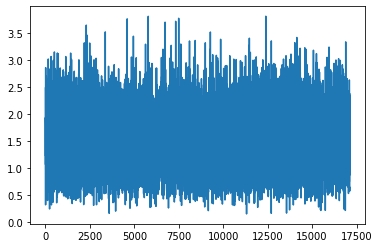

In [0]:
#Train evidence CNN 
evidence_encoder = vgg16(pretrained = True)
evidence_classifier = Vgg_classifier()

criterion = nn.CrossEntropyLoss() 
ev_parameters_to_optimize = evidence_encoder.parameters() 
ev_optimizer = optim.SGD(ev_parameters_to_optimize, lr=LR_tgt, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
ev_scheduler = optim.lr_scheduler.StepLR(ev_optimizer, step_size=STEP_SIZE, gamma=GAMMA)

evidence_loss_vector = []

evidence_encoder = tgt_model  
evidence_classifier = src_classifier

cudnn.benchmark

current_step = 0

evidence_encoder = evidence_encoder.to(DEVICE)
evidence_classifier = evidence_classifier.to(DEVICE)

for epoch in range(NUM_EPOCHS):
    for images,labels in saliency_dataloader:

      evidence_encoder.train()
      evidence_classifier.train()

      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      ev_optimizer.zero_grad()

      out = evidence_classifier(evidence_encoder(images))

      loss = criterion(out,labels)
      evidence_loss_vector.append(loss)


      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      loss.backward()  
      ev_optimizer.step() 

      current_step += 1

    ev_scheduler.step()

plt.plot(evidence_loss_vector)
plt.show()

In [0]:
#FINAL TEST ACCURACY ON TEST DATASET 
#Evaluation for target encoder by source classifier on target dataset

top_classes = 3

softmax = torch.nn.Softmax()

#full vgg for compute saliency map
tgt_full = vgg16(pretrained = True)
features_fn = tgt_full.features
classifier_fn = nn.Sequential(*([Flatten()] + list(tgt_full.classifier.children())))

features_fn = features_fn.to(DEVICE)
classifier_fn = classifier_fn.to(DEVICE)

tgt_encoder = tgt_encoder.to(DEVICE)
tgt_encoder.train(False)

src_classfier = src_classifier.to(DEVICE)
src_classifier.train(False)

evidence_encoder = evidence_encoder.to(DEVICE)
evidence_encoder.train(False)

evidence_classifier = evidence_classifier.to(DEVICE)
evidence_classifier.train(False)  

# init loss and accuracy

running_corrects = 0
running_corrects_ev = 0
running_corrects_gz = 0
# set loss function
criterion = nn.CrossEntropyLoss()
tgt_accuracy = 0
# evaluate network
for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = src_classifier(tgt_encoder(images))

    #Get predictions conventional cnn
    _, pred = torch.max(outputs.data, 1)

    pb = np.array([])
    pb_ev = np.array([])
    lb = []
    lb_ev = []
    images_batch = np.zeros((16,3,224,224))

    
    for i in range(BATCH_SIZE):

      probabilities = softmax(outputs[i])
      top3_prob, top3_label = torch.topk(probabilities,top_classes)
      top3_prob = torch.tensor(top3_prob, device = 'cpu').float()

      if(top3_label[0]< top3_label[1]):
        if(top3_label[0]<top3_label[2]):
          lb.append(top3_label[0])
          pb = np.append(pb,top3_prob[0])
          if(top3_label[1]<top3_label[2]):
            lb.append(top3_label[1])
            pb = np.append(pb,top3_prob[1])
            lb.append(top3_label[2])
            pb = np.append(pb,top3_prob[2])
          else:
            lb.append(top3_label[2])
            pb = np.append(pb,top3_prob[2])
            lb.append(top3_label[1])
            pb = np.append(pb,top3_prob[1])
        else:
          lb.append(top3_label[2])
          pb = np.append(pb,top3_prob[2])
          lb.append(top3_label[0])
          pb = np.append(pb,top3_prob[0])
          lb.append(top3_label[1])
          pb = np.append(pb,top3_prob[1])
      else:
        if(top3_label[1]<top3_label[2]):
          lb.append(top3_label[1])
          pb = np.append(pb,top3_prob[1])           
          if(top3_label[0]<top3_label[2]):
            lb.append(top3_label[0])
            pb = np.append(pb,top3_prob[0])
            lb.append(top3_label[2])
            pb = np.append(pb,top3_prob[2])
          else:
            lb.append(top3_label[2])
            pb = np.append(pb,top3_prob[2])
            lb.append(top3_label[0])
            pb = np.append(pb,top3_prob[0])
        else:
          lb.append(top3_label[2])
          pb = np.append(pb,top3_prob[2])
          lb.append(top3_label[1])
          pb = np.append(pb,top3_prob[1])
          lb.append(top3_label[0])
          pb = np.append(pb,top3_prob[0])           

      
      sal = GradCAM(images, i, features_fn, classifier_fn)
      sal = Image.fromarray(sal)
      sal = sal.resize((224, 224), resample=Image.LINEAR)
      #from cuda a cpu to numpy
      images = images.cpu()

      #from tensor to image
      img = denormalize(images[i])
      images_batch[i] = images[i]
      
    #to tensor and to device(gpu)
    img = torch.tensor(img, device = DEVICE).float()
    images_batch = torch.tensor(images_batch, device = DEVICE).float()
    images_batch.to(DEVICE)

    #Test on evidence cnn  
    out = evidence_classifier(evidence_encoder(images_batch))

    _, pred_ev = torch.max(out.data, 1)

    mean = np.array([])

    for j in range(BATCH_SIZE):
      probabilities_evidence = softmax(out[j])
      top3_prob_ev, top3_label_ev = torch.topk(probabilities_evidence,top_classes)
      top3_prob_ev = torch.tensor(top3_prob_ev, device = 'cpu').float()

      if(top3_label_ev[0]< top3_label_ev[1]):
        if(top3_label_ev[0]<top3_label_ev[2]):
          lb_ev.append(top3_label_ev[0])
          pb_ev = np.append(pb_ev,top3_prob_ev[0])
          if(top3_label_ev[1]<top3_label_ev[2]):
            lb_ev.append(top3_label_ev[1])
            pb_ev = np.append(pb_ev,top3_prob_ev[1])
            lb_ev.append(top3_label_ev[2])
            pb_ev = np.append(pb_ev,top3_prob_ev[2])
          else:
            lb_ev.append(top3_label_ev[2])
            pb_ev = np.append(pb_ev,top3_prob_ev[2])
            lb_ev.append(top3_label_ev[1])
            pb_ev = np.append(pb_ev,top3_prob_ev[1])
        else:
          lb_ev.append(top3_label_ev[2])
          pb_ev = np.append(pb_ev,top3_prob_ev[2])
          lb_ev.append(top3_label_ev[0])
          pb_ev = np.append(pb_ev,top3_prob_ev[0])
          lb_ev.append(top3_label_ev[1])
          pb_ev = np.append(pb_ev,top3_prob_ev[1])
      else:
        if(top3_label_ev[1]<top3_label_ev[2]):
          lb_ev.append(top3_label_ev[1])
          pb_ev = np.append(pb_ev,top3_prob_ev[1])           
          if(top3_label_ev[0]<top3_label_ev[2]):
            lb_ev.append(top3_label_ev[0])
            pb_ev = np.append(pb_ev,top3_prob_ev[0])
            lb_ev.append(top3_label_ev[2])
            pb_ev = np.append(pb_ev,top3_prob_ev[2])
          else:
            lb_ev.append(top3_label_ev[2])
            pb_ev = np.append(pb_ev,top3_prob_ev[2])
            lb_ev.append(top3_label_ev[0])
            pb_ev = np.append(pb_ev,top3_prob_ev[0])
        else:
          lb_ev.append(top3_label_ev[2])
          pb_ev = np.append(pb_ev,top3_prob_ev[2])
          lb_ev.append(top3_label_ev[1])
          pb_ev = np.append(pb_ev,top3_prob_ev[1])
          lb_ev.append(top3_label_ev[0])
          pb_ev = np.append(pb_ev,top3_prob_ev[0])  

      mean = np.append(mean,(pb[j*3:(j*3)+3]+pb_ev[j*3:(j*3)+3])/2)
      ind = np.argmax(mean[j*3:(j*3)+3])
      if(labels[j] == lb[ind]):
        running_corrects_gz+=1


    # Update Corrects conventional
    running_corrects += torch.sum(pred == labels.data).data.item()
    #Update corrects evidence 
    running_corrects_ev += torch.sum(pred_ev == labels.data).data.item()

# Calculate Accuracy
tgt_accuracy = running_corrects / float(len(test_dataset))

evidence_accuracy = running_corrects_ev / float(len(test_dataset))

print('Test Accuracy on Target Domain: {}'.format(tgt_accuracy)) 
print()
print('Test Accuracy of the Evidence CNN on the target Domain: {}'.format(evidence_accuracy)) 
print()
print("Refined Prediction: {}".format(running_corrects_gz))

  0%|          | 0/1610 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:150: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 1610/1610 [43:30<00:00,  1.62s/it]

Test Accuracy on Target Domain: 0.5230201863354037

Test Accuracy of the Evidence CNN on the target Domain: 0.5230201863354037

Refined Prediction: 1237
